# Business Understanding
In the threat space for defense, there is a growing need to determine threats and provide a quick decisive counter measure.  The goal of this project is to determine what data provides the best thread fingerprint and deliver a model that can accurately determine that threat.
We will be using a public dataset that will act as a RF threat dataset.  The data being used to train and test the delivered model can be found [here](https://www.kaggle.com/datasets/suraj520/rf-signal-data).  The reason for a stand-in dataset is that actual threat data is held classified and we will not be able to obtain that data.


# Data Understanding
Here we will explore the dataset and get a sense of which features will give us the best categorization model.


In [2]:
# Import all libraries needed for the study
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re
import scipy.stats as stats
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
import warnings
warnings.filterwarnings('ignore')

In [16]:
# Import the data
df = pd.read_csv('data/logged_data.zip', compression='zip')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164160 entries, 0 to 164159
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Timestamp          164160 non-null  object 
 1   Frequency          164160 non-null  int64  
 2   Signal Strength    164160 non-null  int64  
 3   Modulation         164160 non-null  object 
 4   Bandwidth          164160 non-null  int64  
 5   Location           164160 non-null  object 
 6   Device Type        164160 non-null  object 
 7   Antenna Type       164160 non-null  object 
 8   Temperature        164160 non-null  int64  
 9   Humidity           164160 non-null  int64  
 10  Wind Speed         164160 non-null  int64  
 11  Precipitation      164160 non-null  float64
 12  Weather Condition  164160 non-null  object 
 13  Interference Type  122821 non-null  object 
 14  Battery Level      164160 non-null  float64
 15  Power Source       164160 non-null  bool   
 16  CP

We can see that there's features in the data that do not pertain to the RF signal.  

In [4]:
print(df.isna().sum())
print('Total missing cells ' + str(df.isna().sum().sum()))
print('Percentage of missing cells ' + str(df.isna().sum().sum()/df.size * 100))

Timestamp                 0
Frequency                 0
Signal Strength           0
Modulation                0
Bandwidth                 0
Location                  0
Device Type               0
Antenna Type              0
Temperature               0
Humidity                  0
Wind Speed                0
Precipitation             0
Weather Condition         0
Interference Type     41339
Battery Level             0
Power Source              0
CPU Usage                 0
Memory Usage              0
WiFi Strength             0
Disk Usage                0
System Load               0
Latitude                  0
Longitude                 0
Altitude(m)               0
Air Pressure         164160
Device Status             0
I/Q Data              54836
dtype: int64
Total missing cells 260335
Percentage of missing cells 5.873560573243809


We can see that some columns have null/NA values.  The 'Interference Type' and 'Air Pressure' don't matter and we will likely remove those columns.  For the I/Q data, there are quite a few missing values.  Removing those rows will allow us to use the I/Q column but will limit our train and test sets.  I'll try both having the I/Q and dropping it to see if the results are different.

In [5]:
# Look for any columns that have very few values
for col in df.columns:
    print(col + " number of unique values: " + str(len(df[col].value_counts())))

Timestamp number of unique values: 164160
Frequency number of unique values: 6
Signal Strength number of unique values: 101
Modulation number of unique values: 6
Bandwidth number of unique values: 6
Location number of unique values: 1
Device Type number of unique values: 3
Antenna Type number of unique values: 4
Temperature number of unique values: 21
Humidity number of unique values: 61
Wind Speed number of unique values: 21
Precipitation number of unique values: 164160
Weather Condition number of unique values: 3
Interference Type number of unique values: 3
Battery Level number of unique values: 1
Power Source number of unique values: 1
CPU Usage number of unique values: 73
Memory Usage number of unique values: 25
WiFi Strength number of unique values: 101
Disk Usage number of unique values: 1
System Load number of unique values: 25
Latitude number of unique values: 1
Longitude number of unique values: 1
Altitude(m) number of unique values: 1
Air Pressure number of unique values: 0
D

As we can see there are many columns that only have a single or very few unique values.  These will not add to the model at all.

# Data Preparation
Here we are going to start the data preparations.  First, we will transform the data to view the cross correlation table to verify the removed columns are correctly selected.

In [6]:
# Transform the columns to numeric so a correlation can be run.
# Timestamp
from datetime import datetime
df_num = pd.DataFrame(df, copy=True)
func = lambda x : (datetime.strptime(x, "%Y-%m-%d %H:%M:%S") - datetime(1970,1,1)).total_seconds()
df_num['Timestamp'] = df_num['Timestamp'].apply(func)

In [7]:
# Fix up the I/Q column
# Split out the complex numbers first
pattern_split = r'\([-+0-9.j]*\)'

def StrToComplexList(s):
    if(type(s) is str):
        str_list = re.findall(pattern_split, s)
        return [np.real(complex(iq.strip('()'))) for iq in str_list]
    return None

complex_lambda = lambda x : StrToComplexList(x)

# Each list with I/Q Data consists of 100 samples
print(len(df_num['I/Q Data'].apply(complex_lambda)[0]))

def padOrTruncateList(l, size, fillValue):
    if len(l) < size:
        return l + [fillValue] * (size - len(l))
    if len(l) > size:
        return l[:size]

# Create a column for each sample.
df_num['I/Q Data'] = df_num['I/Q Data'].apply(complex_lambda)
df_num = df_num.dropna(subset='I/Q Data')
df_num[['X.'+str(i) for i in range(100)]] = pd.DataFrame(df_num['I/Q Data'].tolist(), index=df_num.index)

df_num.info()


100
<class 'pandas.core.frame.DataFrame'>
Index: 109324 entries, 0 to 164159
Columns: 127 entries, Timestamp to X.99
dtypes: bool(1), float64(111), int64(7), object(8)
memory usage: 106.0+ MB


In [8]:
def LabelEncodeCol(dataframe : pd.DataFrame, col : str):
    print(dataframe[col].value_counts().index.to_list())
    le = LabelEncoder().fit(dataframe[col].value_counts().index.to_list())
    dataframe[col] = le.transform(dataframe[col])
    print(dataframe[col].value_counts().index.to_list())


LabelEncodeCol(df_num, 'Modulation')
LabelEncodeCol(df_num, 'Location')
LabelEncodeCol(df_num, 'Device Type')
LabelEncodeCol(df_num, 'Antenna Type')
LabelEncodeCol(df_num, 'Weather Condition')
LabelEncodeCol(df_num, 'Device Status')
df_num['Interference Type'] = df_num['Interference Type'].fillna('None')
LabelEncodeCol(df_num, 'Interference Type')
df_num['Air Pressure'] = df_num['Air Pressure'].fillna(0)
df_num = df_num.drop('I/Q Data', axis=1)
df_num.corr() # This is non-normalized

['AM', '8PSK', 'FM', 'BPSK', 'QAM', 'QPSK']
[1, 0, 3, 2, 4, 5]
['Patna, Bihar']
[0]
['HackRF', 'Halow-U']
[0, 1]
['Directional', 'Omnidirectional', 'Dipole', 'Yagi']
[1, 2, 0, 3]
['Rainy', 'Sunny', 'Cloudy']
[1, 2, 0]
['Streaming I/Q data', 'Transmitting beacon signal']
[0, 1]
['None', 'Adjacent-channel', 'Intermodulation', 'Co-channel']
[3, 0, 2, 1]


,Timestamp,Frequency,Signal Strength,Modulation,Bandwidth,Location,Device Type,Antenna Type,Temperature,Humidity,...,X.90,X.91,X.92,X.93,X.94,X.95,X.96,X.97,X.98,X.99
Timestamp,1.000000,0.002854,0.000171,-0.000796,0.000009,NaN,0.002574,-0.001340,-0.001483,0.002996,...,-0.000634,0.001823,-0.005794,0.001960,0.000140,-0.001646,-0.005677,0.001171,-0.001608,0.005285
Frequency,0.002854,1.000000,-0.001418,-0.003343,-0.008041,NaN,-0.000992,0.003675,0.004268,0.000454,...,-0.003548,-0.002177,0.000784,-0.000522,-0.005448,0.003349,-0.003711,-0.004882,-0.001498,-0.001636
Signal Strength,0.000171,-0.001418,1.000000,-0.000136,0.000014,NaN,-0.003264,0.004147,0.000866,-0.002111,...,0.004332,-0.002768,0.001922,0.002669,0.001060,0.000433,-0.001071,0.001079,0.001903,0.000519
Modulation,-0.000796,-0.003343,-0.000136,1.000000,0.002356,NaN,-0.001808,-0.001394,0.000232,0.000958,...,0.000950,-0.002251,-0.000886,0.000064,0.005361,0.004887,-0.000627,-0.004905,-0.000818,0.002907
Bandwidth,0.000009,-0.008041,0.000014,0.002356,1.000000,NaN,-0.000024,-0.000361,-0.001185,0.000141,...,-0.002532,-0.000691,0.003987,0.000307,-0.004306,0.005109,0.001739,0.006100,0.001835,0.000023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X.95,-0.001646,0.003349,0.000433,0.004887,0.005109,NaN,-0.003923,0.005155,0.001749,-0.000681,...,0.004157,-0.003800,0.002598,0.000376,0.003877,1.000000,0.002909,-0.001243,-0.004011,-0.001486
X.96,-0.005677,-0.003711,-0.001071,-0.000627,0.001739,NaN,-0.000538,0.002761,-0.003055,-0.004948,...,0.003165,0.002396,0.000617,0.001032,0.001342,0.002909,1.000000,0.000949,0.002863,-0.004420
X.97,0.001171,-0.004882,0.001079,-0.004905,0.006100,NaN,-0.001867,-0.000276,0.003983,-0.000855,...,0.000448,-0.000858,0.000068,-0.001918,-0.002266,-0.001243,0.000949,1.000000,0.001374,-0.004416
X.98,-0.001608,-0.001498,0.001903,-0.000818,0.001835,NaN,-0.004150,0.000588,-0.002082,0.003084,...,0.001578,-0.002231,0.000282,-0.001180,0.001362,-0.004011,0.002863,0.001374,1.000000,0.003871


In [9]:
# Remove the data that doesn't pertain to the RF signal
df_clean = df_num.drop(['Timestamp',
                        'Location',
                        'Temperature',
                        'Humidity',
                        'Wind Speed',
                        'Precipitation',
                        'Weather Condition',
                        'Battery Level',
                        'Power Source',
                        'CPU Usage',
                        'Memory Usage',
                        'WiFi Strength',
                        'Disk Usage',
                        'System Load',
                        'Altitude(m)',
                        'Air Pressure',
                        'Latitude',
                        'Longitude',
                        'Device Status'], axis=1)
df_clean.corr()

df_clean = df_clean.fillna(0)

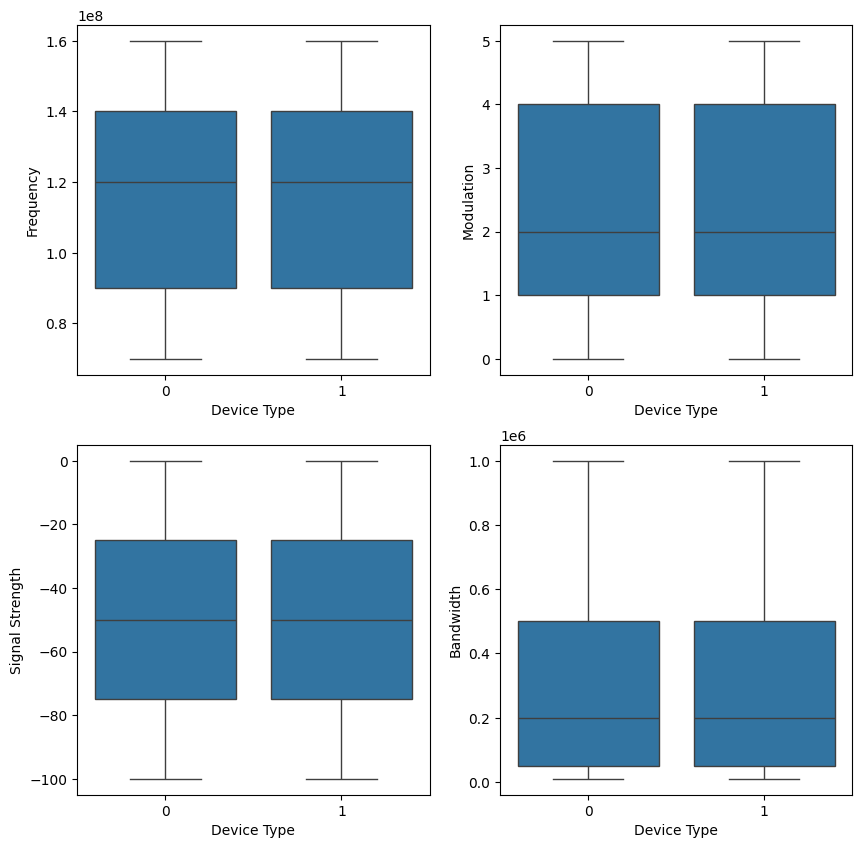

In [14]:
fit, axes = plt.subplots(2,2,figsize=(10,10))
sns.boxplot(data=df_clean, x='Device Type', y='Frequency', ax=axes[0,0])
sns.boxplot(data=df_clean, x='Device Type', y='Signal Strength', ax=axes[1,0])
sns.boxplot(data=df_clean, x='Device Type', y='Modulation', ax=axes[0,1])
sns.boxplot(data=df_clean, x='Device Type', y='Bandwidth', ax=axes[1,1])

plt.show()

This plot is another indication that the data itself has almost no variance.

After trying some basics, our baseline model was only performing at a coin toss rate.  Trying a boosting classifier didn't give much improvement.  We're coming back to this step to try and pull the most impactful features out.

In [24]:
scaler = StandardScaler()

X = df_clean.drop('Device Type', axis=1)
X_scaled = scaler.fit_transform(X)
y = df_clean['Device Type']

pca = PCA(n_components=30)
X_pca = pca.fit_transform(X_scaled)
print(pca.explained_variance_ratio_)
print(X)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y)

[0.01002887 0.00998948 0.00998107 0.00994748 0.00991927 0.00990769
 0.00989503 0.00988483 0.00987123 0.00985426 0.00983561 0.00982206
 0.00981105 0.00980285 0.00979079 0.00977508 0.00977066 0.00976039
 0.00974933 0.00973424 0.00972753 0.00970953 0.00970638 0.00969644
 0.00968653 0.00968212 0.00966679 0.00966455 0.00964889 0.00963555]
        Frequency  Signal Strength  Modulation  ...      X.97      X.98      X.99
0       120000000              -44           4  ...  0.107356 -0.218302 -0.024590
1       160000000              -97           3  ... -0.906330  0.889742 -0.042698
2        90000000              -87           2  ...  0.441079  0.453712 -0.505968
3       160000000              -29           3  ...  0.894170 -0.092471 -0.567800
4        70000000              -26           0  ... -0.105228 -0.940590 -0.875037
...           ...              ...         ...  ...       ...       ...       ...
164153   90000000              -85           1  ...  0.843756 -0.260087  0.903926
164154  

# Modeling

Make a baseline model to compare to our final model.

In [25]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression())
])
pipe.fit(X_train, y_train)
print(pipe.score(X_test, y_test))

0.4998719402875855


We can see here that a LogisticRegression model on its own is not sufficient.  Looking at the correlation matrix again we can see that we are left over features are loosely tied to the device type.  This will suggest using a boosting type classifier.

In [26]:
pipe_tree = Pipeline([
    ('scaler', StandardScaler()),
    ('tree', DecisionTreeClassifier())
])
pipe_tree.fit(X_train, y_train)
print(pipe_tree.score(X_test, y_test))

0.49544473308697085


The decision tree classifier performed slightly better than the logistic regression.  Let's try a boosting model with a decision tree classifier as the base model.

In [27]:
pipe_boost = Pipeline([
    ('scaler', StandardScaler()),
    ('boost', AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=1000))
])
pipe_boost.fit(X_train, y_train)
print(pipe_boost.score(X_test, y_test))


0.4929567158172039


In [229]:
pipe_boost = Pipeline([
    ('scaler', StandardScaler()),
    ('boost', AdaBoostClassifier(LogisticRegression(), n_estimators=1000))
])
pipe_boost.fit(X_train, y_train)
print(pipe_boost.score(X_test, y_test))


0.4994694669057115


In [231]:
pipe_forest = Pipeline([
    ('scaler', StandardScaler()),
    ('forest', RandomForestClassifier())
])
pipe_forest.fit(X_train, y_train)
print(pipe_forest.score(X_test, y_test))

0.4994328784164502


Looking at the ensemble methods we can see that we didn't get much of an improvement.  This means we need to do some more work on our dataset.  We'll head back to the data preparation stage and employ PCA to see if we can get some dimensionality reduced and improve the classifier.

# Evaluation

I've evaluated a few models with the cleaned data.  There is almost no variance in the data for each device type.  Given there's only two devices a 50% accuracy rate tells me that the models are as good as a coin toss.  Using ensemble models didn't help clear up the the low variance.  I saw almost no improvement in the accuracy scores.  I looked deeper into the data and PCA showed that the component with the most variance only explained 1% of the overall variance.

Next steps here is to evaluate the data further.  However, the data appears to have almost no variance.

# Deployment
The current models I've looked at aren't even close to deployable.  The accuracy scores aren't high enough to even grid search the model parameters.